In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)

# Build your input pipeline
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
for example in ds.take(1):
  image, label = example["image"], example["label"]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'<br /><br />Ok the film wasn\'t going to win any awards and it is pure bubblegum, and it is a modern update on "It\'s a wonderful life". But it\'s just come out as a cheap release on DVD and there are a lot worse ways of blowing $13. You get a film that has a surprisingly strong cast but for most they were still a year or two from becoming B list celebs. However it\'s an enjoyable way of passing an hour and half just don\'t think too much in it.'
 b'Once in a while in Indian cinema there comes along a movie like Sholay that changes the way the audience perceives a good movie. And den just once in a while(hopefully) we have a RGV ki Aag that breaks all the standards and creates one of its own. A standard so low, it can never be broken. Ram Gopal varma manages to take a melting pot of talent and create a dish so stale u can smell it from a distance. To take a classic like Sholay and assassinate it is totally unforgivable and I can\'t believe he almost called the movie RGV ki S

Buat Teks Encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [12]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 13,  13, 597, ...,   0,   0,   0],
       [272,   8,   4, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]])

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'<br /><br />Ok the film wasn\'t going to win any awards and it is pure bubblegum, and it is a modern update on "It\'s a wonderful life". But it\'s just come out as a cheap release on DVD and there are a lot worse ways of blowing $13. You get a film that has a surprisingly strong cast but for most they were still a year or two from becoming B list celebs. However it\'s an enjoyable way of passing an hour and half just don\'t think too much in it.'
Round-trip:  br br ok the film wasnt going to [UNK] any [UNK] and it is [UNK] [UNK] and it is a modern [UNK] on its a wonderful life but its just come out as a cheap release on dvd and there are a lot worse ways of [UNK] [UNK] you get a film that has a [UNK] strong cast but for most they were still a year or two from [UNK] b [UNK] [UNK] however its an enjoyable way of [UNK] an hour and half just dont think too much in it                                                                                                                

Model ini dapat dibuat sebagai tf.keras.Sequential.
 Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.

Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.

Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.

Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

-Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

-Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.

Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00754666]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 360ms/step
[-0.00754666]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##Train Model

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 693s 2s/step - loss: 0.6744 - accuracy: 0.5098 - val_loss: 0.6128 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 655s 2s/step - loss: 0.5412 - accuracy: 0.7314 - val_loss: 0.4626 - val_accuracy: 0.7917
Epoch 3/10
391/391 [==============================] - 663s 2s/step - loss: 0.4047 - accuracy: 0.8207 - val_loss: 0.3720 - val_accuracy: 0.8307
Epoch 4/10
391/391 [==============================] - 662s 2s/step - loss: 0.3485 - accuracy: 0.8462 - val_loss: 0.3500 - val_accuracy: 0.8448
Epoch 5/10
391/391 [==============================] - 663s 2s/step - loss: 0.3302 - accuracy: 0.8560 - val_loss: 0.3426 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 649s 2s/step - loss: 0.3214 - accuracy: 0.8620 - val_loss: 0.3410 - val_accuracy: 0.8474
Epoch 7/10
391/391 [==============================] - 645s 2s/step - loss: 0.3156 - accuracy: 0.8641 - val_loss: 0.3566 - val_accuracy: 0.8250

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 160s 408ms/step - loss: 0.3247 - accuracy: 0.8537
Test Loss: 0.3246864080429077
Test Accuracy: 0.8536800146102905


In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6928216814994812)

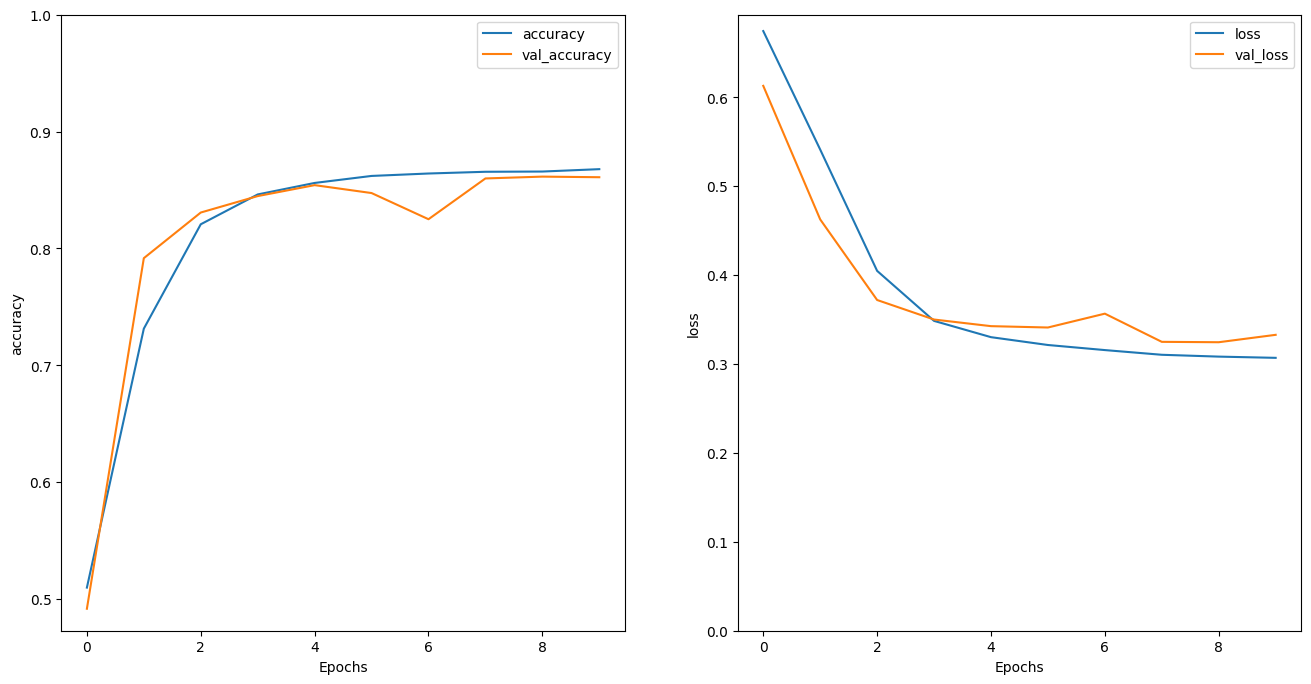

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [28]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


Stack two or more LSTM layers

In [30]:
model = tf.keras.Sequential([
   encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                validation_data=test_dataset,
                validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1395s 4s/step - loss: 0.6153 - accuracy: 0.6039 - val_loss: 0.4276 - val_accuracy: 0.8109
Epoch 2/10
111/391 [=======>......................] - ETA: 15:14 - loss: 0.4123 - accuracy: 0.8231